# Chapter 1 Code

Covers code for Chapter 1, "A Deep Dive Into Keras", of *Modern Deep Learning Design and Application*.

---

## Installing + Importing Libraries

In [1]:
# array processing + math
import numpy as np
import pandas as pd
import math

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# looping - very helpful for data manpulation scripts
from tqdm.notebook import tqdm

# deep learning staple libraries
# !pip install tensorflow # install if necessary
import sklearn
import tensorflow as tf
from tensorflow import keras

# keras specifics
import keras.layers as L
import keras.backend as K
from keras.utils import plot_model

---

## The Simple Keras Workflow

### Step '0': Get Data

In [2]:
data = pd.DataFrame({'A':[0,1,0,0,1,1],
                     'B':[0,0,1,1,1,1],
                     'C':[0,0,0,1,0,1],
                     'Label 1':[0,1,1,1,1,1],
                     'Label 2':[0,0,0,1,1,1]})
data

,A,B,C,Label 1,Label 2
0,0,0,0,0,0
1,1,0,0,1,0
2,0,1,0,1,0
3,0,1,1,1,1
4,1,1,0,1,1
5,1,1,1,1,1


### Step 1: Define Architecture

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

# initializes sequential model
model = Sequential()

# input layer
model.add(Input((3,)))

# layer with 10 nodes and ReLU activation
model.add(Dense(10, activation='relu'))

# layer with 5 nodes and ReLU activation
model.add(Dense(5, activation='relu'))

# layer with 2 nodes and sigmoid activation (output)
model.add(Dense(2, activation='sigmoid'))

### Step 2: Compile

In [4]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['mae','accuracy'])

For a custom loss function (example - MSE):

In [5]:
import keras.backend as K
def custom_mse(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true))

### Step 3: Fit and Evaluate

Define callbacks. Note that normally we would monitor the validation loss (`monitor='val_loss'`) but in this case our dataset is too small to separate into training and validation datasets.

In [6]:
import keras.callbacks as C
mc = C.ModelCheckpoint(filepath='best-weights.h5',
                       save_weights_only=True,
                       monitor='loss',
                       mode='min',
                       save_best_only=True)
es = C.EarlyStopping(monitor="loss",
                     min_delta=0,
                     patience=3)
rp = C.ReduceLROnPlateau(monitor="loss",
                         patience=3,
                         factor=0.1)


Fitting model on the data with the callbacks.

In [7]:
model.fit(x=np.array(data[['A','B','C']]),
          y=np.array(data[['Label 1','Label 2']]),
          epochs=1, # only training for 1 epoch
          callbacks=[mc, es, rp])

1/1 [==============================] - 1s 665ms/step - loss: 0.6290 - mae: 0.4623 - accuracy: 1.0000


Plotting history.

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - loss: 0.6272 - mae: 0.4613 - accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 0s 3ms/step - loss: 0.6254 - mae: 0.4603 - accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.6236 - mae: 0.4592 - accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 3ms/step - loss: 0.6218 - mae: 0.4582 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 0.6200 - mae: 0.4572 - accuracy: 1.0000


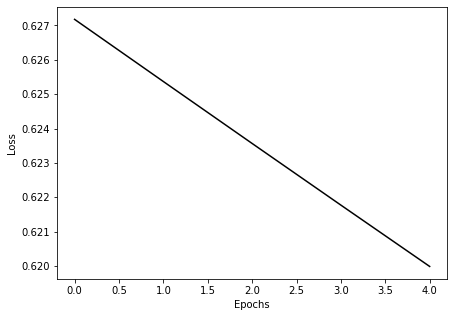

In [8]:
history = model.fit(x=np.array(data[['A','B','C']]),
                    y=np.array(data[['Label 1','Label 2']]),
                    epochs=5,
                    callbacks=[mc, es, rp])
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], color='black')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

---

## Visualizing Model Architectures

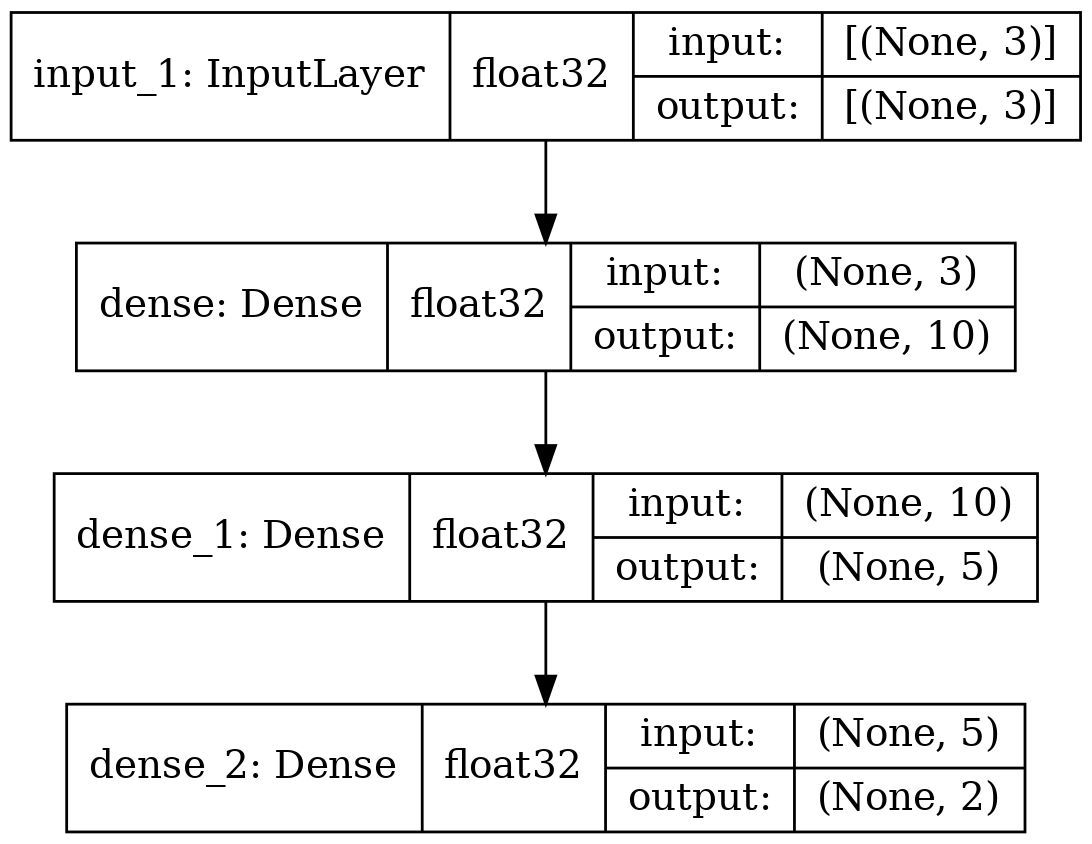

In [9]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True,
           to_file='diagram.png', dpi=200)

---

## Functional API

### Translating Model from Sequential to Functional Syntax

Translate the following Sequential model -
```python
model = Sequential()
model.add(L.Input((3,)))
model.add(L.Dense(10, activation=’relu’))
model.add(L.Dense(5, activation=’relu’))
model.add(L.Dense(2, activation='sigmoid'))
```
\- into Functional API syntax.

In [10]:
import keras.layers as L

# define all layers
input_layer = L.Input((3,))
dense_1 = L.Dense(10, activation='relu')(input_layer)
dense_2 = L.Dense(5, activation='relu')(dense_1)
output_layer = L.Dense(2, activation='sigmoid')(dense_2)

# aggregate into model
model = keras.Model(inputs=input_layer, outputs=output_layer)

Using Functional API with repeated variable assignment.

In [11]:
# define all layers
input_layer = L.Input((3,))
x = L.Dense(10, activation='relu')(input_layer)
x = L.Dense(5, activation='relu')(x)
x = L.Dense(2, activation='sigmoid')(x)

# aggregate into model
model = keras.Model(inputs=input_layer, outputs=x)

### Build Nonlinear Topologies

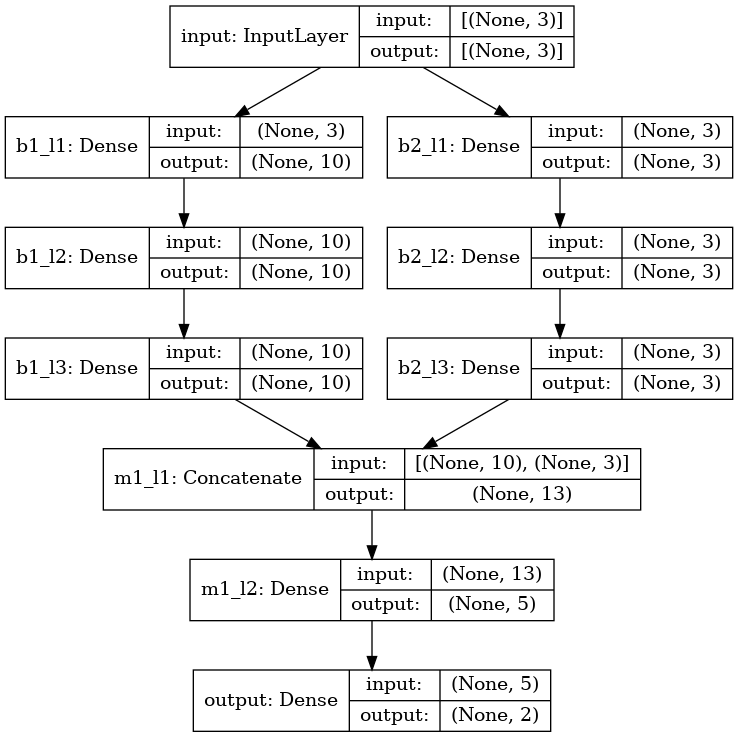

In [12]:
import keras.layers as L
input_layer = L.Input((3,), name='input')

b1_l1 = L.Dense(10, name='b1_l1')(input_layer)
b1_l2 = L.Dense(10, name='b1_l2')(b1_l1)
b1_l3 = L.Dense(10, name='b1_l3')(b1_l2)

b2_l1 = L.Dense(3, name='b2_l1')(input_layer)
b2_l2 = L.Dense(3, name='b2_l2')(b2_l1)
b2_l3 = L.Dense(3, name='b2_l3')(b2_l2)

m1_l1 = L.Concatenate(name='m1_l1')([b1_l3, b2_l3])
m1_l2 = L.Dense(5, name='m1_l2')(m1_l1)
output_layer = L.Dense(2, name='output')(m1_l2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

plot_model(model, show_shapes=True)

---

## Dealing with Data

### TensorFlow Dataset from Loaded Data

Define NumPy arrays.

In [13]:
X_train = np.array(data[['A','B','C']])
y_train = np.array(data[['Label 1','Label 2']])

Convert into TensorFlow dataset.

In [14]:
from tensorflow.data import Dataset as d
train_data = d.from_tensor_slices((X_train, y_train))

# shuffle
train_data = train_data.shuffle(len(X_train))

# batch
train_data = train_data.batch(2)

### TensorFlow Dataset from Image Files

Select and download image files as prerequisite for demonstration.

In [15]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, y_train = x_train[np.where((y_train==1)|(y_train==2))], y_train[np.where((y_train==1)|(y_train==2))]

import os
os.mkdir('data')
os.mkdir('data/class_1')
os.mkdir('data/class_2')

for ind in tqdm(range(len(x_train))):
    if y_train[ind] == 1:
        plt.imsave(f'data/class_1/{ind}.png', x_train[ind])
    else:
        plt.imsave(f'data/class_2/{ind}.png', x_train[ind])

170500096/170498071 [==============================] - 2s 0us/step


  0%|          | 0/10000 [00:00<?, ?it/s]

Create function to parse files.

In [16]:
def parse_files(filename, label):
    raw_image = tf.io.read_file(filename) 
    image = tf.image.decode_jpeg(raw_image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [512,512]) 
    return image, label 

Create array of directory names and map parsing function.

In [17]:
file_names_1 = np.array(['data/class_1/'+name for name in os.listdir('data/class_1')])
labels_1 = np.array([[1] for i in range(len(file_names_1))])
file_names_2 = np.array(['data/class_2/'+name for name in os.listdir('data/class_2')])
labels_2 = np.array([[2] for i in range(len(file_names_2))])

file_names = np.concatenate([file_names_1, file_names_2])
labels = np.concatenate([labels_1, labels_2])

unparsed_data = d.from_tensor_slices((file_names, labels))

Map parsing function to path.

In [18]:
parsed_data = unparsed_data.map(parse_files)

View `parsed_data` specifics:

In [19]:
parsed_data

<MapDataset shapes: ((512, 512, 3), (1,)), types: (tf.float32, tf.int64)>

### Automatic Image Dataset from Directory

In [20]:
from keras.preprocessing import image_dataset_from_directory
train_data = image_dataset_from_directory(directory='data',
                                          batch_size=32,
                                          image_size=(256, 256))

Found 10000 files belonging to 2 classes.


---